In [27]:
# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')
import string

from sklearn import model_selection
from sklearn import set_config
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import nltk
from sklearn.svm import SVC

import seaborn as sns

# Pour éviter l'affichage tronqué des descriptions
pd.set_option('display.max_colwidth', -1) 
# Pour la visualisation des pipelines sklearn
set_config(display='diagram')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/maxime/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/maxime/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# First experimentations with english dataset and simple models

## 1. Importation des données

In [28]:
# Recuperation des données
tweet_df = pd.read_csv('data/tweets_eng.csv', index_col=0)

# Suppression des lignes avec des valeurs manquantes
tweet_df = tweet_df.dropna()

# Suppression des colonnes inutiles
tweet_df = tweet_df.drop(columns=['selected_text'])

In [29]:
tweet_df['sentiment'].value_counts()

neutral     11117
positive    8582 
negative    7781 
Name: sentiment, dtype: int64

In [30]:
# Convertit les genres en labels numériques
tweet_df['label'] = tweet_df['sentiment'].astype('category')
tweet_df['label'] = tweet_df['label'].cat.codes

In [31]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, cb774db0d1 to 6f7127d9d7
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
 2   label      27480 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 670.9+ KB


In [32]:
X_train, X_test, y_train, y_test = train_test_split(tweet_df['text'], tweet_df['label'], test_size=0.2, random_state=42, shuffle=True)

## 2. Preprocessing

In [33]:
# download spacy model
#!python3 -m spacy download en_core_web_sm

In [34]:
from preprocessing import preprocess_texts, preprocess_text

In [35]:
# preprocess X_train and X_test
X_train_pre = preprocess_texts(X_train,'lemm')
X_test_pre = preprocess_texts(X_test, 'lemm')

In [36]:
# convert X_train_pre, X_test_pre, y_train, y_test to numpy array
X_train_pre = np.array(X_train_pre)
X_test_pre = np.array(X_test_pre)
y_train = np.array(y_train)
y_test = np.array(y_test)

## 3. W2V

In [37]:
from w2v import wtv_vectorizer_doc, wtv_vectorizer, vectorize

In [ ]:
# download model from google drive if not exist
try:
    open('models/GoogleNews-vectors-negative300.bin.gz')
except FileNotFoundError:
    !gdown --id {"https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?usp=sharing&resourcekey=0-wjGZdNAUop6WykTtMip30g".split("/")[-2]}

In [ ]:
# unzip the file (gz) and move it to the models folder
!gunzip GoogleNews-vectors-negative300.bin.gz
!mv GoogleNews-vectors-negative300.bin models/

In [ ]:
# download another model (not from google drive)
!wget -c "https://nlp.stanford.edu/data/glove.twitter.27B.zip"
!unzip glove.twitter.27B.zip

In [ ]:
!rm glove.twitter.27B.zip
!rm glove.twitter.27B.25d.txt
!rm glove.twitter.27B.50d.txt
!rm glove.twitter.27B.200d.txt
!mv glove.twitter.27B.100d.txt models/

In [38]:
# word2vec

# sous la forme (chemin, taille_des_vecteurs, nom_à_afficher)
models_wtv = [
    ("models/GoogleNews-vectors-negative300.bin",300, "google news"),
    ("models/glove.twitter.27B.100d.txt",100, "glove twitter")
    # ("models/frWac_non_lem_no_postag_no_phrase_200_cbow_cut0.bin",200, "200 cbow")
    # ("models/frWiki_no_lem_no_postag_no_phrase_1000_cbow_cut100.bin",1000,"1000 cbow"),
    # ("models/frWiki_no_lem_no_postag_no_phrase_1000_skip_cut100.bin",1000,"1000 skip")
]

# download models if not already done
""" for model in models_wtv:
    try:
        open(model[0])
    except:
        print("downloading model", model[0].split("/")[-1].split(".")[0])
        # download the model from google drive
        !gdown --id {model[3].split("/")[-2]} """

In [40]:
# chargement des modèles word2vec
models_wtv_loaded = []
for path,vec_size,name in models_wtv:
    print(f"loading w2v model {name}")
    # if the model is not a bin file, we use KeyedVectors.load_word2vec_format with binary=False
    if path.split(".")[-1] == "bin":
        models_wtv_loaded.append((KeyedVectors.load_word2vec_format(
            path,
            binary=True,
            unicode_errors="ignore"),
        vec_size,
        name
        ))
    else:
        models_wtv_loaded.append((KeyedVectors.load_word2vec_format(
            path,
            binary=False,
            unicode_errors="ignore",
            no_header=True),
        vec_size,
        name
        ))

loading w2v model google news


## 4. Comparaison des modèles et des prétraitements

In [ ]:
# for each w2v model, we vectorize X_train and X_test, and we train a SVM classifier, then we evaluate the model and we store the results
results = []
for model, size, name in models_wtv_loaded:
    X_train_vec = wtv_vectorizer_doc(X_train_pre, model, size)
    X_test_vec = wtv_vectorizer_doc(X_test_pre, model, size)
    # convert X_train_vec and X_test_vec to numpy array
    X_train_vec = np.array(X_train_vec)
    X_test_vec = np.array(X_test_vec)
    print(f"training model {name}")
    clf = SVC(kernel="rbf", C=1, gamma="auto")
    clf.fit(X_train_vec[name], y_train)
    X_test_vec = vectorize(X_test_pre, [(model, _, name)])
    y_pred = clf.predict(X_test_vec[name])
    results.append((name, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")))

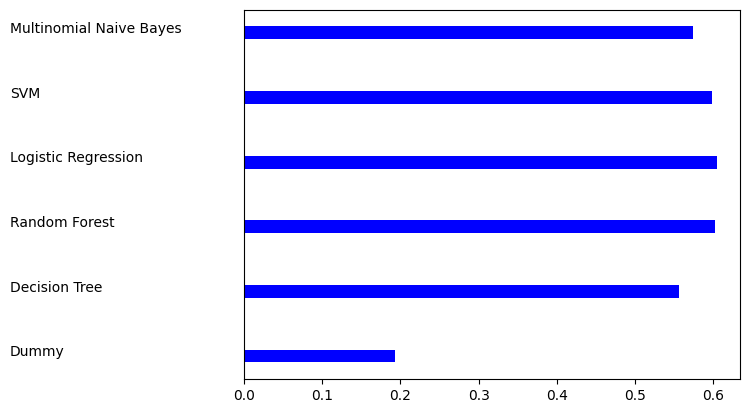

In [25]:
# Print models name and accuracy
for name, score in results:
    print(f"{name} : {score}")

## 5. Evaluation SVM

In [22]:
# train the model
model = SVC()
model.fit(X_train_vec["google news"], y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocess_pipeline',
                                  FunctionTransformer(func=<function preprocess_texts at 0x7fe3bea352d0>,
                                                      kw_args={'stem_lemm': 'stem'})),
                                 ('vectorizer_pipeline',
                                  TfidfVectorizer(min_df=0.005,
                                                  tokenizer=<function <lambda> at 0x7fe3bea35990>))])),
                ('svc', SVC())])

              precision    recall  f1-score   support

           0       0.70      0.43      0.53      1572
           1       0.58      0.79      0.67      2236
           2       0.76      0.66      0.71      1688

    accuracy                           0.65      5496
   macro avg       0.68      0.63      0.63      5496
weighted avg       0.67      0.65      0.64      5496



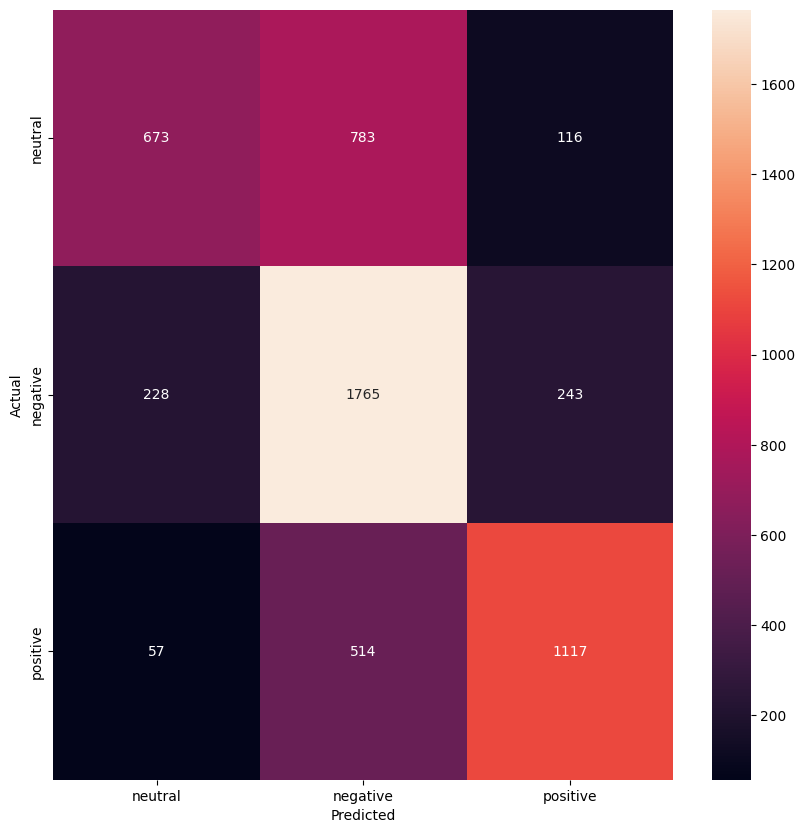

In [23]:
# Evaluation du modèle
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matrice de confusion

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=tweet_df['sentiment'].unique(), yticklabels=tweet_df['sentiment'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()